In [1080]:
import numpy as np
import matplotlib.pyplot as plt

In [1081]:
timecalc = 9
tolerance = 1e-7

# load the data
p_ind_read, frame_read, x_read, y_read = np.genfromtxt(
    "./20170202c059_RPE1_CAG_H2B_Halotag_TMR80pM_nonlam_non_starve_ctrl_info.txt",
    unpack=True,
)

# data
data = np.array([p_ind_read, frame_read, x_read, y_read])
data = data.T

In [1082]:
# print all shapes
print("data.shape", data.shape)
print("data[0] : ", data[0])

data.shape (11579, 4)
data[0] :  [  1.     0.   148.37 108.4 ]


In [1083]:
class Nucleosome:
    def __init__(self, p_ind, data):
        self.p_ind = p_ind
        self.traj = self.get_traj(data)
        self.in_time = self.traj[0, 0]
        self.out_time = self.traj[-1, 0]
        
    
    def get_traj(self, data):
        traj = data[data[:, 0] == self.p_ind]
        traj = traj[:, 1:4]                         # have only [frame, x, y]
        return traj
    

In [1084]:
# initialize nucleosomes
nucleosomes = []
for p_ind in np.unique(data[:, 0]):
    nucleosomes.append(Nucleosome(p_ind, data))

In [1085]:
# print all shapes
# print("nucleosomes[0].traj.shape", nucleosomes[0].traj.shape)
# print("nucleosomes[0].traj[0] : ", nucleosomes[0].traj[0])

# print all in and out times
# for n in nucleosomes:
#     print("nucleosome {} : in_time = {}, out_time = {}".format(n.p_ind, n.in_time, n.out_time))

In [1086]:
# plot all trajectories with different colors for each nucleosome based on p_ind
# for n in nucleosomes:
#     color = np.random.rand(3,)
#     plt.scatter(n.traj[:, 1], n.traj[:, 2], color=color)

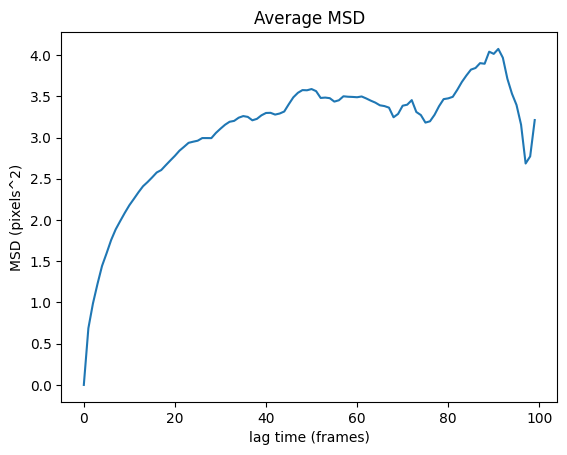

In [1087]:
# calculate average MSD for each lag time 

num_frames = int(max(data[:, 1]))
if min(data[:, 1]) == 0:
    num_frames += 1

msd = np.zeros(num_frames)
msd_count = np.zeros(num_frames)

for n in nucleosomes:
    for i in range(1, n.traj.shape[0]):
        # vectorized
        # print(n.traj[i,0])
        msd[i] += np.sum((n.traj[i:, 1:3] - n.traj[0:-i, 1:3])**2)
        msd_count[i] += n.traj.shape[0] - i

# average
msd[0] = 0
msd_count[0] = 1
msd = msd / msd_count
# print(msd)

# plot
plt.plot(msd)
plt.xlabel("lag time (frames)")
plt.ylabel("MSD (pixels^2)")
plt.title("Average MSD")
plt.show()

# save
np.savetxt("msd.txt", msd)


In [1088]:
# calculate self part of van Hove function for each lag time
r_vals = np.arange(0, 10.01, 0.02)
# print(r_vals.shape)
van_hove = np.zeros((num_frames, r_vals.shape[0]-1))

for n in nucleosomes:
    for i in range(1, n.traj.shape[0]):
        # vectorized
        dist = np.linalg.norm(n.traj[i:, 1:3] - n.traj[0:-i, 1:3], axis=1)
        hist, _ = np.histogram(dist, bins=r_vals)
        van_hove[i, :] += hist

# average
van_hove = van_hove / len(nucleosomes)

# calc the area of the van hove function at each lag time
area = np.zeros(num_frames)
for i in range(num_frames):
    area[i] = np.sum(van_hove[i, :]) * (r_vals[1] - r_vals[0])
    # normalize
    if(area[i] == 0):
        area[i] = 1
    van_hove[i, :] = van_hove[i, :] / area[i]
    # print(f"area at lag time {i} : {area[i]}")

# divide by 2pi r dr
# van_hove = van_hove / (2 * np.pi * r_vals[1:]).reshape(1, -1) * (r_vals[1] - r_vals[0])
van_hove = van_hove / (2 * np.pi * r_vals[1:]).reshape(1, -1)

print(f"shape of van hove : {van_hove.shape}")

# save 
np.savetxt("van_hove.txt", van_hove)



shape of van hove : (100, 500)


/tmp/ipykernel_17680/3818925511.py:21: RuntimeWarning: invalid value encountered in divide
  van_hove[i, :] = van_hove[i, :] / area[i]


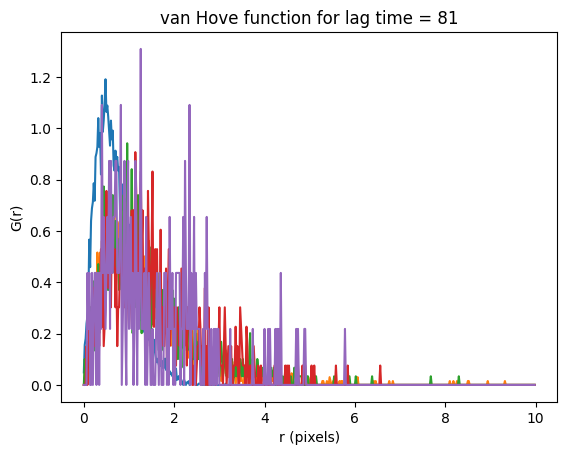

In [1089]:
# plot van Hove function for lag time = i
for i in range(1, num_frames, 20):
    plt.plot(r_vals[:-1], van_hove[i, :] * 2 * np.pi * r_vals[1:])
    # plt.plot(r_vals[:-1], van_hove[i, :])
    plt.xlabel("r (pixels)")
    plt.ylabel("G(r)")
    plt.title(f"van Hove function for lag time = {i}")
    # plt.show()

Lucy-Richardson Iterative Algorithm

$\\$
$P^{k+1}(M) = P^{k}(M) \int \frac{G_s(r)}{G^{k}_s(r)}e^{\frac{-r^2}{M}}dr$, $\\ where \\$
$G^k_s(r) = \int P^k(M)e^{\frac{-r^2}{M}}dM$

In [1090]:
# get P_init as the guessed value of P(M, t)

P = np.zeros((num_frames, r_vals.shape[0]-1))
print(f"shape of P : {P.shape}")

# M_vals = np.linspace(0, max(msd), len(r_vals)-1)
M_vals = np.linspace(0, 25.0, len(r_vals)-1)
M_vals[0] = 1e-10
print(f"shape of M_vals : {M_vals.shape}")

shape of P : (100, 500)
shape of M_vals : (500,)


shape of G_pred : (100, 500)


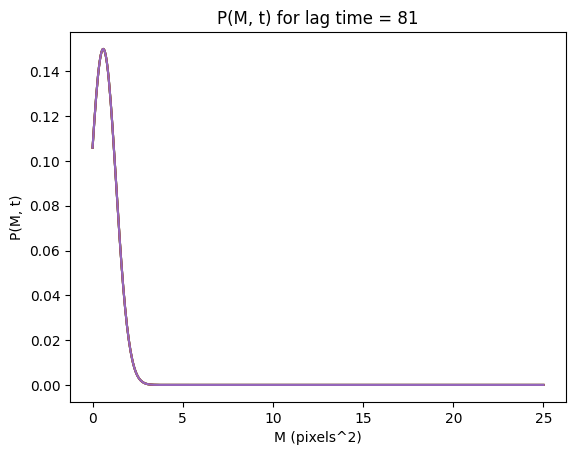

In [1091]:
# initialize P
a1 = 0.15
a = 1.0
a0 = 0.59
for i in range(P.shape[0]):
        P[i] = a1 * np.exp(-a * (M_vals - a0)**2)
P_old = P.copy()

# plot P
for i in range(1, num_frames, 20):
    plt.plot(M_vals, P[i, :])
    plt.xlabel("M (pixels^2)")
    plt.ylabel("P(M, t)")
    plt.title(f"P(M, t) for lag time = {i}")
    # plt.show()

# integrate to get G_pred
G_pred = np.zeros((num_frames, r_vals.shape[0]-1))
# G_pred = van_hove.copy()
print(f"shape of G_pred : {G_pred.shape}")

In [1092]:
def integ1(G_pred, P, r_vals, M_vals):
    # try and integrate $G^k_s(r) = \int P^k(M)e^{\frac{-r^2}{M}}dM$
    # do this in a vectorized way using numpy

    # integrate using trapezoidal rule over M
    # for i in range(G_pred.shape[0]):
    #     for j in range(G_pred.shape[1]):
    #         G_pred[i, j] = np.trapz(P[i, :] * np.exp(-r_vals[j] ** 2 / M_vals) * (1/(M_vals*np.pi)), M_vals)
    
    e_pow_r2_into_m = np.exp(np.outer(-r_vals[:-1]*r_vals[:-1], 1/M_vals)) * (1/(M_vals*np.pi))
    for i in range(G_pred.shape[0]):
        G_pred[i] = np.trapz(P[i] * e_pow_r2_into_m, M_vals)
    

    # normalize G_pred by dividing each element by sum of its row + 1
    G_pred = G_pred / (np.sum(G_pred, axis=1) + 1).reshape(-1, 1)
    # print(((np.sum(G_pred, axis=1) + 1).reshape(-1, 1)).shape)

    # shape
    # print(f"shape of G_pred : {G_pred.shape}")
    return G_pred


def integ2(G_pred, P, r_vals, M_vals, ratio):
    # now update P using $P^{k+1}(M) = P^{k}(M) \int \frac{G_s(r)}{G^{k}_s(r)}e^{\frac{-r^2}{M}}dr$
    # do this in a vectorized way using numpy

    # update P

    # for i in range(1, P.shape[0]):
    #     for j in range(P.shape[1]):
    #         P[i, j] *= np.trapz(
    #             van_hove[i, :] / G_pred[i, :]
    #             * np.exp(-r_vals[:-1] ** 2 / M_vals[j]) * (1/(M_vals[j]*np.pi))
    #             * (2 * np.pi * r_vals[:-1]),
    #             r_vals[:-1],
    #         )

    # vals in G_pred which are smaller than tolerance are set to 0
    G_pred[G_pred < tolerance] = 0.0
    e_pow_r2_into_m = np.exp(np.outer(1/M_vals, -r_vals[:-1]**2)) * (1/(M_vals*np.pi)).reshape(-1, 1)
    for i in range(1, P.shape[0]):
        # get temp as van_hove / G_pred, but if G_pred is 0, set temp to 1
        ratio = np.divide(van_hove[i], G_pred[i], out=np.ones_like(van_hove[i]), where=G_pred[i] != 0)
        P[i] *= np.trapz(ratio * e_pow_r2_into_m * (2 * np.pi * r_vals[:-1]), r_vals[:-1])
        # the below is for testing equivalence with the for loop implementation
        # P[i] *= np.trapz(van_hove[i, :] / G_pred[i, :] * e_pow_r2_into_m * (2 * np.pi * r_vals[:-1]), r_vals[:-1])


    
    # normalize P by dividing each element by sum of its row + 1
    P = P / (np.sum(P, axis=1) + 1).reshape(-1, 1)

    # shape
    # print(f"shape of P : {P.shape}")
    return P

In [1093]:
# iterate until delta is small enough
delta = 10000
num_iter = 0
temp = np.ones_like(G_pred)
while delta > 1e-7:
    G_pred = integ1(G_pred, P, r_vals, M_vals)
    P = integ2(G_pred, P, r_vals, M_vals, temp)
    delta = np.sum((P - P_old)**2)
    print(f"delta : {delta}")
    P_old = P.copy()
    num_iter += 1
print(f"num_iter : {num_iter}")

delta : 33.04266443378833
delta : 0.3213056067847683
delta : 0.14226061918408947
delta : 0.07276770349428424
delta : 0.04300344015404937
delta : 0.027699651685145186
delta : 0.01907907521383267
delta : 0.013730887379933684
delta : 0.010260622504812907
delta : 0.007955027775355073
delta : 0.006333725434505571
delta : 0.0051655177522348765
delta : 0.004297558907385252
delta : 0.003655443599605106
delta : 0.003136908873030866
delta : 0.0027262010381789575
delta : 0.0024104288724898565
delta : 0.002151318831412776
delta : 0.001936210425543807
delta : 0.0017523975565494638
delta : 0.001597108918757882
delta : 0.0014770262166773462
delta : 0.00136474912513534
delta : 0.0012611576555451144
delta : 0.0011694111627405161
delta : 0.0010869332683351154
delta : 0.0010125619875926849
delta : 0.0009436874459815106
delta : 0.0008827970805951774
delta : 0.0008259257051929752
delta : 0.0007744894711408964
delta : 0.0007266338713724747
delta : 0.0006835755710970266
delta : 0.0006436004380269506
delta : 

In [1099]:
# normalize the G_pred by making the area under each curve = 1
area = np.zeros(num_frames)
for i in range(num_frames):
    area[i] = np.trapz(G_pred[i, :] * 2 * np.pi * r_vals[1:], r_vals[:-1])
    # area[i] = np.trapz(G_pred[i, :], r_vals[:-1])
    G_pred[i, :] /= area[i]

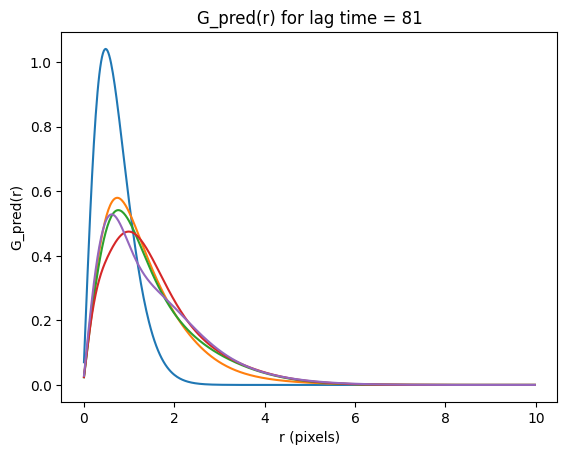

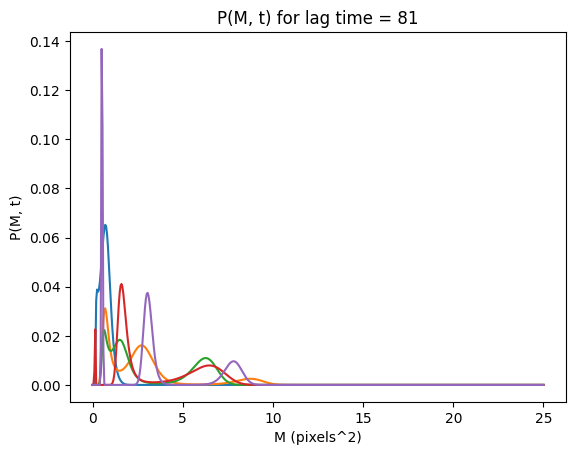

In [1100]:
# plot G_pred
for i in range(1, num_frames, 20):
    plt.plot(r_vals[:-1], G_pred[i, :] * 2 * np.pi * r_vals[1:])
    # plt.plot(r_vals[:-1], G_pred[i, :])
    plt.xlabel("r (pixels)")
    plt.ylabel("G_pred(r)")
    plt.title(f"G_pred(r) for lag time = {i}")
    # plt.show()
plt.show()

# plot P
for i in range(1, num_frames, 20):
    plt.plot(M_vals, P[i, :])
    plt.xlabel("M (pixels^2)")
    plt.ylabel("P(M, t)")
    plt.title(f"P(M, t) for lag time = {i}")
    # plt.show()
plt.show()

# save P
np.savetxt("P.txt", P)


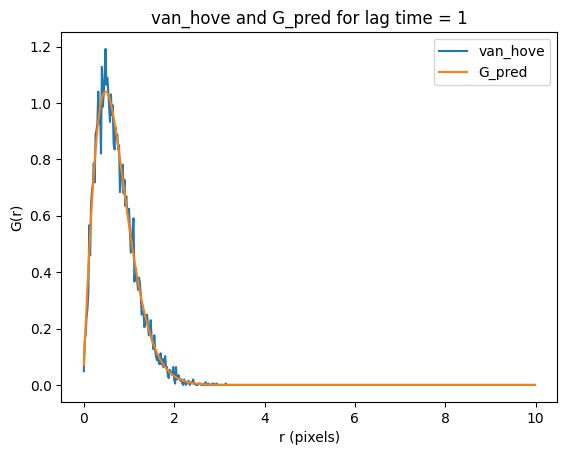

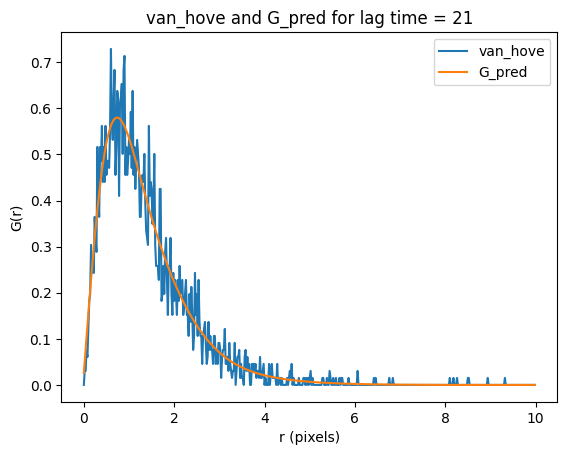

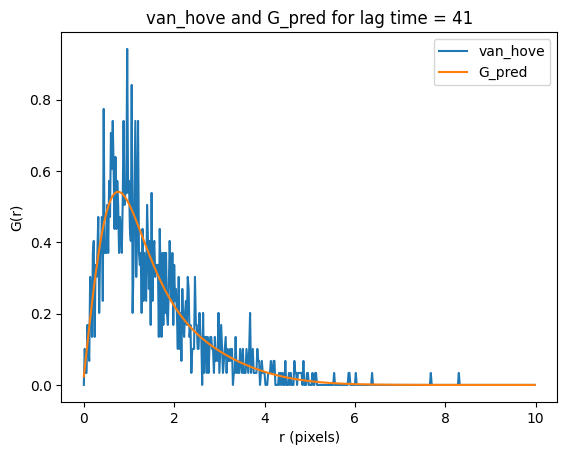

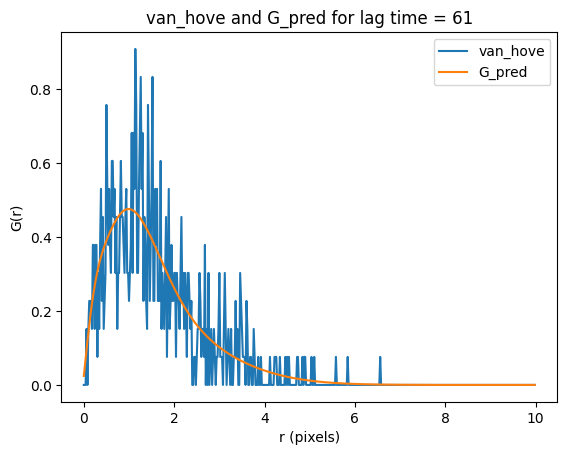

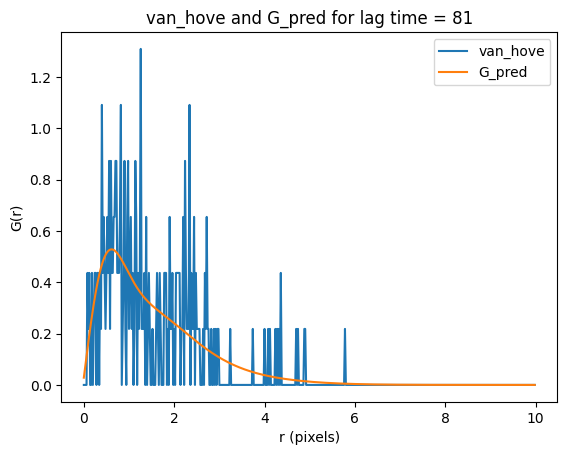

In [1101]:
# compare van_hove and G_pred
for i in range(1, num_frames, 20):
    plt.plot(r_vals[:-1], van_hove[i, :] * 2 * np.pi * r_vals[1:], label="van_hove")
    plt.plot(r_vals[:-1], G_pred[i, :] * 2 * np.pi * r_vals[1:], label="G_pred")
    plt.xlabel("r (pixels)")
    plt.ylabel("G(r)")
    plt.title(f"van_hove and G_pred for lag time = {i}")
    plt.legend()
    plt.show()